In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from category_encoders.target_encoder import TargetEncoder, OrdinalEncoder
from sklearn import tree
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

from sklearn.utils import class_weight

In [2]:
X = pd.read_csv('Training_Dataset.csv')
test_X =  pd.read_csv('Test_Dataset.csv')

In [3]:
y = pd.read_csv('Labels.csv')
test_y = pd.read_csv('Labels_Test.csv')

In [4]:
# Delete useless features told by Shirish
X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign'], axis = 1, inplace = True)

test_X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
             'Family_Name', 'Malware_Category', 'Malware/Benign'], axis = 1, inplace = True)

## Feature Exploration

#### Find the one-hot features having missing values

In [5]:
X.describe().loc['count'][X.describe().loc['count'] < 10951]

sdkVersion          0.0
targetSdkVersion    0.0
Name: count, dtype: float64

In [6]:
# Delete these useless features (100% missing values)
X = X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)
test_X = test_X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)

In [7]:
# Check if there's no onehot feature has missing values
X.describe().loc['count'][X.describe().loc['count'] < 10951]

Series([], Name: count, dtype: float64)

**There's no one-hot features having missing values**

#### Remove features with 0 variance

In [8]:
X.max()[X.max() == 0].index.to_list()

['Permission: REQUEST_DELETE_PACKAGES',
 'Permission: BIND_MIDI_DEVICE_SERVICE',
 'Permission: BIND_TV_INPUT',
 'Permission: com.android.voicemail.permission.ADD_VOICEMAIL',
 'Permission: com.android.launcher.permission.UNINSTALL_SHORTCUT',
 'Permission: READ_PHONE_NUMBERS',
 'Permission: GET_ACCOUNTS_PRIVILEGED',
 'Permission: REQUEST_COMPANION_RUN_IN_BACKGROUND',
 'Permission: ANSWER_PHONE_CALLS',
 'Permission: BIND_CARRIER_SERVICES',
 'Permission: REQUEST_IGNORE_BATTERY_OPTIMIZATIONS',
 'Permission: ACCESS_NOTIFICATION_POLICY',
 'Permission: com.android.voicemail.permission.READ_VOICEMAIL',
 'Permission: BODY_SENSORS',
 'Permission: BIND_SCREENING_SERVICE',
 'Permission: REQUEST_COMPANION_USE_DATA_IN_BACKGROUND',
 'Permission: BIND_TELECOM_CONNECTION_SERVICE',
 'Permission: BIND_VOICE_INTERACTION',
 'Permission: BIND_CHOOSER_TARGET_SERVICE',
 'Permission: com.android.launcher.permission.INSTALL_SHORTCUT',
 'Permission: BIND_AUTOFILL_SERVICE',
 'Permission: USE_FINGERPRINT',
 'Permis

In [9]:
drop_features = X.max()[X.max() == 0].index.to_list()
X.drop(drop_features, axis = 1, inplace = True)
test_X.drop(drop_features, axis = 1, inplace = True)

## Feature Summary:


### Original Dataset:

#### (1) Missing Values:
   + Features with 100% missing values: 'sdkVersion', 'targetSdkVersion' (deleted)


#### (2) Features with 0 Variance:
  + Number of Features with 0 Variance: 511 (deleted)


### Preprocessed Dataset:

#### (1) Categories of Features:
  + Number of one-hot features: 352
 
 
#### (2) Features Extracted by Us
  + Number of featuers extracted by us (sensors): 29

## Correlation Between Features and Target

In [10]:
chi_2, p = chi2(X, y)

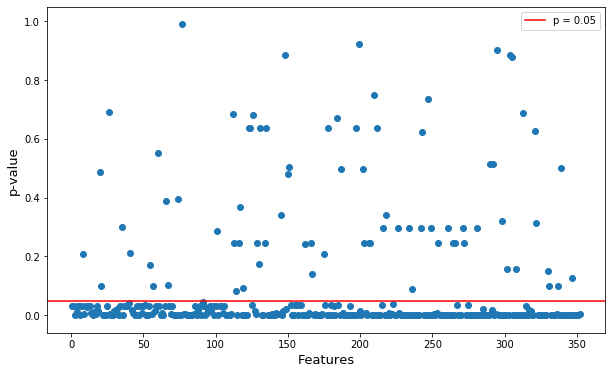

In [11]:
plt.figure(figsize = (10, 6))
plt.scatter(np.arange(1, 353), p)
plt.axhline(y=0.05, color='r', linestyle='-', label = 'p = 0.05')
plt.xlabel('Features', fontsize = 13)
plt.ylabel('p-value', fontsize = 13)
plt.legend()

In [12]:
print('The number of features that are correlated with the target (p-value < 0.05) is:', np.sum(p < 0.05))

The number of features that are correlated with the target (p-value < 0.05) is: 273


## Distribution of Target

Text(0.5, 1.0, 'Distribution of Target')

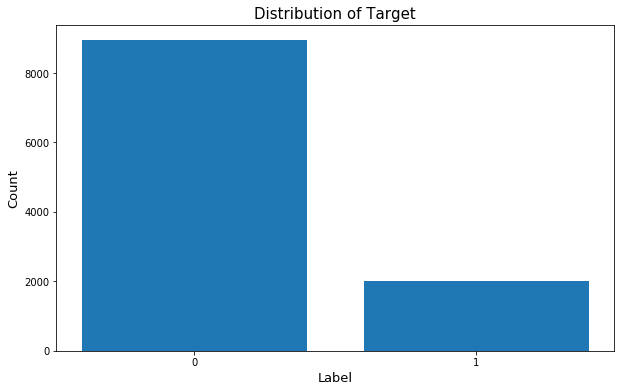

In [13]:
plt.figure(figsize = (10, 6))
plt.bar(['0', '1'], y['label'].value_counts().values)
plt.xlabel('Label', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.title('Distribution of Target', fontsize = 15)

  + **Need to deal with imbalanced dataset.**

In [14]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y),
                                                  y['label'].values)
print("Class weights should be: %f for 0 and %f for 1" % (class_weights[0], class_weights[1]))

Class weights should be: 2.732285 for 0 and 0.611993 for 1


In [15]:
class_weights = {0: class_weights[0], 1: class_weights[1]}

## Splitting Training and Test set

In [16]:
# Create dataset without sensor features in order to see if there's some improvement by adding sensor features
X_wo_sensors = X.drop(X.iloc[:, -29:].columns, axis = 1)

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

X_train_wo_sensor, X_test_wo_sensor, y_train_wo_sensor, y_test_wo_sensor = train_test_split(X_wo_sensors, y, 
                                                                                            test_size = 0.2, 
                                                                                            random_state = 123, 
                                                                                            stratify = y)

## Building Pipelines and Training Logistic Regression Model

In [18]:
continuous = make_column_selector(dtype_exclude = 'object')

pipe = make_pipeline(SelectKBest(k = 273, score_func=chi2), 
                     LogisticRegression(class_weight = class_weights, max_iter = 1000))

In [19]:
avg_val_score = np.mean(cross_val_score(pipe, X_train, np.squeeze(y_train.to_numpy().reshape(1, -1)), cv = 5))
print('The mean test score of Logistic Regression model with sensor features is:', avg_val_score)

The mean test score of Logistic Regression model with sensor features is: 0.8224885844748858


In [20]:
avg_val_score = np.mean(cross_val_score(pipe, X_train_wo_sensor, np.squeeze(y_train.to_numpy().reshape(1, -1)), cv = 5))
print('The mean test score of Logistic Regression model without sensor features is:', avg_val_score)

The mean test score of Logistic Regression model without sensor features is: 0.8226027397260275


## Tuning Hyperparameters

**1. Training on Dataset Including Sensor Features**

In [21]:
# Tune C of Logistic Regression
pipe_with_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                                 LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1]}

grid_with_sensor = GridSearchCV(pipe_with_sensor, param_grid = params)
grid_with_sensor.fit(X_train, y_train['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f90de15b440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.7322854291417165,
                                                                         1: 0.6119928467642786},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
   

In [22]:
result_with_sensor = pd.DataFrame(grid_with_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of Logistic Regression with Different C (Including Sensor Features)')

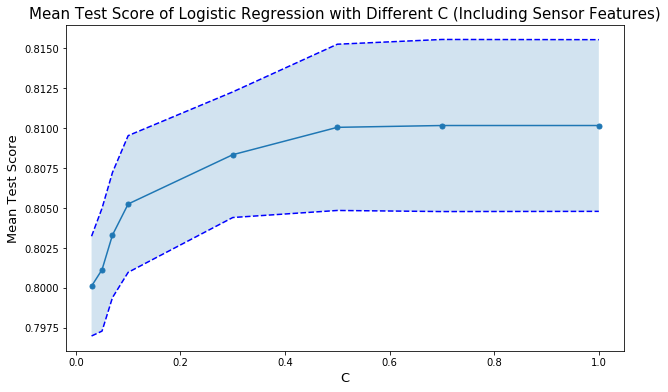

In [23]:
scores = result_with_sensor['mean_test_score']
scores_std = result_with_sensor['std_test_score']
std_error = scores_std / np.sqrt(5)
plt.figure(figsize = (10, 6))
plt.plot([0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1], scores, marker = 'o', markersize = 5)
plt.plot([0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1], scores + std_error, 'b--')
plt.plot([0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1], scores - std_error, 'b--')
plt.fill_between([0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1], scores + std_error, scores - std_error, alpha = 0.2)
plt.xlabel('C', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of Logistic Regression with Different C (Including Sensor Features)', fontsize = 15)

**2. Training on Dataset Not Including Sensor Features**

In [24]:
pipe_wo_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                               LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1]}

grid_wo_sensor = GridSearchCV(pipe_wo_sensor, param_grid = params)
grid_wo_sensor.fit(X_train_wo_sensor, y_train['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f90de15b440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.7322854291417165,
                                                                         1: 0.6119928467642786},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
   

In [25]:
result_wo_sensor = pd.DataFrame(grid_wo_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of Logistic Regression with Different C (Not Including Sensor Features)')

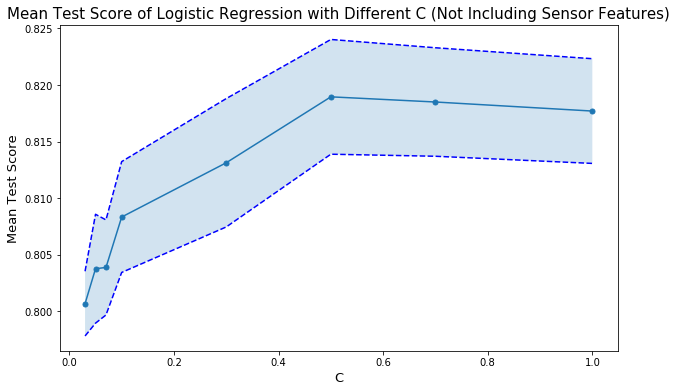

In [26]:
scores = result_wo_sensor['mean_test_score']
scores_std = result_wo_sensor['std_test_score']
std_error = scores_std / np.sqrt(5)
plt.figure(figsize = (10, 6))
plt.plot([0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1], scores, marker = 'o', markersize = 5)
plt.plot([0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1], scores + std_error, 'b--')
plt.plot([0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1], scores - std_error, 'b--')
plt.fill_between([0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1], scores + std_error, scores - std_error, alpha = 0.2)
plt.xlabel('C', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of Logistic Regression with Different C (Not Including Sensor Features)', fontsize = 15)

## Testing

In [27]:
pipe_with_sensor = make_pipeline(SelectKBest(k = 200, score_func=chi2), 
                                 LogisticRegression(C = grid_with_sensor.best_params_['logisticregression__C'], 
                                                    class_weight = class_weights, max_iter = 1000))
pipe_with_sensor.fit(X_train, np.squeeze(y_train.to_numpy().reshape(1, -1)))

pipe_wo_sensor = make_pipeline(SelectKBest(k = 200, score_func=chi2), 
                               LogisticRegression(C = grid_wo_sensor.best_params_['logisticregression__C'],
                                                  class_weight = class_weights, max_iter = 1000))
pipe_wo_sensor.fit(X_train_wo_sensor, np.squeeze(y_train.to_numpy().reshape(1, -1)))

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=200,
                             score_func=<function chi2 at 0x7f90de15b440>)),
                ('logisticregression',
                 LogisticRegression(C=0.5,
                                    class_weight={0: 2.7322854291417165,
                                                  1: 0.6119928467642786},
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [28]:
y_pred_with_sensor = pipe_with_sensor.predict_proba(X_test)
y_pred_wo_sensor = pipe_wo_sensor.predict_proba(X_test_wo_sensor)

AUC (including sensor features) 0.8860460580392594
AUC (not including sensor features) 0.8833530698393681


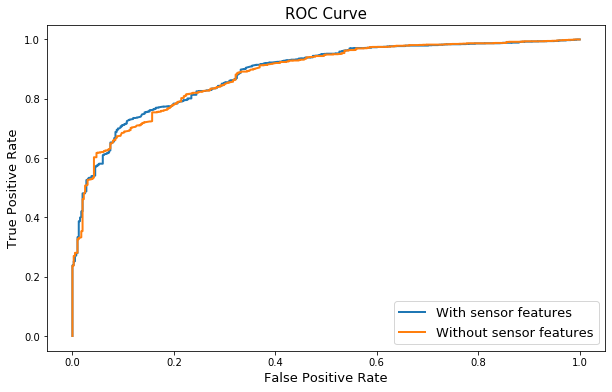

In [29]:
plt.figure(figsize = (10, 6))
fpr, tpr, _ = roc_curve(y_test['label'].values, y_pred_with_sensor[:, 1])
fpr2, tpr2, _2 = roc_curve(y_test['label'].values, y_pred_wo_sensor[:, 1])
plt.plot(fpr, tpr, lw=2, label='With sensor features')
plt.plot(fpr2, tpr2, lw=2, label='Without sensor features')
print('AUC (including sensor features)', roc_auc_score(y_test, y_pred_with_sensor[:, 1]))
print('AUC (not including sensor features)', roc_auc_score(y_test, y_pred_wo_sensor[:, 1]))

plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.title('ROC Curve', fontsize = 15)
plt.legend(fontsize = 13)

**Adding sensor features slightly improves the Logistic Regression model's performance.**

## Other Metrics

In [30]:
y_pred_with_sensor = pipe_with_sensor.predict(X_test)
y_pred_wo_sensor = pipe_wo_sensor.predict(X_test_wo_sensor)

In [31]:
print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(y_test['label'].values, y_pred_with_sensor))
print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(y_test['label'].values, y_pred_wo_sensor))

Balanced Average Accuracy (including sensor features): 0.7859060449435071
Balanced Average Accuracy (not including sensor features): 0.7871731286309366


## Testing on Repackaged Benign Apps Dataset

In [32]:
# Tune C of Logistic Regression
pipe_with_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                                 LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1]}

grid_with_sensor = GridSearchCV(pipe_with_sensor, param_grid = params)
grid_with_sensor.fit(X, y['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f90de15b440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.7322854291417165,
                                                                         1: 0.6119928467642786},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
   

In [33]:
pipe_with_sensor = make_pipeline(SelectKBest(k = 200, score_func=chi2), 
                                 LogisticRegression(C = grid_with_sensor.best_params_['logisticregression__C'], 
                                                    class_weight = class_weights, max_iter = 1000))
pipe_with_sensor.fit(X, np.squeeze(y.to_numpy().reshape(1, -1)))

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=200,
                             score_func=<function chi2 at 0x7f90de15b440>)),
                ('logisticregression',
                 LogisticRegression(C=0.05,
                                    class_weight={0: 2.7322854291417165,
                                                  1: 0.6119928467642786},
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [34]:
accuracy = pipe_with_sensor.score(test_X, test_y['label'].values)

In [35]:
print('Accuracy (including sensor features):', accuracy)

Accuracy (including sensor features): 0.8880335899230231


+ **Logistic Regression can classify 88.8% repackaged benign apps correctly, but still misclassify 11.2% cases.**